In [1]:
PARKINGS = [
    "Gto-Alhondiga",
    "Gto-Alonso",
    "Gto-Hinojo",
    "Gto-SanPedro",
]

In [2]:
import pandas as pd

csv_path = "https://raw.githubusercontent.com/L4rralde/Parking_Lots/refs/heads/main/data/data.csv"

data = pd.read_csv(csv_path)
data = data.drop(columns=["Unnamed: 0"])
data["Fecha_Hora"] = pd.to_datetime(data["Fecha_Hora"])
data.set_index(["Fecha_Hora"], inplace=True)
means = data.mean()
stds = data.std()

data = (data - means)/stds

In [3]:
data["Dia_Semana"] = data.index.weekday
data["Hora"] = data.index.hour
data["Minuto"] = data.index.minute
data["Horas_Semana"] = data["Dia_Semana"]*24 + data["Hora"]
data["Minutos_Semana"] = data["Dia_Semana"]*1440 + data["Hora"]*60 + data["Minuto"]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import KFold


train, test = train_test_split(data, test_size=0.2, shuffle=False)

kf = KFold(n_splits=10, shuffle=False)
folds = [
    (train.iloc[train_idx], train.iloc[val_idx])
    for train_idx, val_idx in kf.split(train)
]


In [31]:
data

,Gto-Alhondiga,Gto-Alonso,Gto-Hinojo,Gto-Pozuelos,Gto-SanPedro,Irapuato-Hidalgo,Leon-Mariachi,Dia_Semana,Hora,Minuto,Horas_Semana,Minutos_Semana
Fecha_Hora,,,,,,,,,,,,
2025-02-19 15:15:15,-0.713756,-1.121610,0.287800,-1.396729,0.019261,-0.104120,-0.337040,2,15,15,63,3795
2025-02-19 15:20:15,-0.767050,-1.121610,0.287800,-1.267812,-0.055231,-0.074947,-0.392574,2,15,20,63,3800
2025-02-19 15:25:16,-0.660461,-1.121610,0.228405,-1.249395,-0.017985,-0.104120,-0.309273,2,15,25,63,3805
2025-02-19 15:30:16,-0.687109,-1.089224,0.169011,-1.230978,0.019261,-0.104120,-0.253739,2,15,30,63,3810
2025-02-19 15:35:17,-0.687109,-0.959678,0.287800,-1.120477,-0.017985,-0.162466,-0.225972,2,15,35,63,3815
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-08 13:45:35,-0.367343,-0.538654,-1.018884,-1.175727,0.410347,0.187609,-1.808692,1,13,45,37,2265
2025-04-08 13:55:37,-0.420637,-0.635814,-0.900095,-1.175727,0.410347,0.158436,-1.669857,1,13,55,37,2275
2025-04-08 14:20:50,-0.393990,-0.441495,-0.781305,-1.286228,0.410347,0.333473,-1.753158,1,14,20,38,2300


In [32]:
predictors = ["Dia_Semana", "Hora", "Minuto"]
response = ["Gto-Alonso"]

In [33]:
train_set, val_set = folds[0]

In [34]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor


class BoostingRegressionTree:
    def __init__(self, n_trees: int, shrinkage: float, splits: int, **kwargs) -> None:
        self._shrinkage = shrinkage
        self._trees = [
            DecisionTreeRegressor(
                max_leaf_nodes = splits+1,
                **kwargs
            )
            for _ in range(n_trees)
        ]

    def fit(self, X: np.ndarray, y: np.ndarray) -> "BoostingRegressionTree":
        r = y
        for tree in self._trees:
            tree.fit(X, r)
            r = r - self._shrinkage*tree.predict(X)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        yhat = 0
        for tree in self._trees:
            yhat += tree.predict(X)
        yhat *= self._shrinkage
        return yhat

In [35]:
n_trees = 100
boosting_tree = BoostingRegressionTree(
    n_trees = n_trees,
    shrinkage = 1/n_trees,
    splits = 60
)

In [36]:
import matplotlib.pyplot as plt

In [37]:
def mse(model, subset, predictors, response):
    val_y = subset[response].values.ravel()
    val_yhat = model.predict(subset[predictors])
    return ((val_y - val_yhat)**2).mean()

def cross_validation(model, predictors, response):
    train_error = 0
    val_error = 0
    for i, (train_set, val_set) in enumerate(folds):
        model.fit(train_set[predictors], train_set[response].values.ravel())
        train_error += mse(model, train_set, predictors, response)
        val_error += mse(model, val_set, predictors, response)
    return (train_error/len(folds), val_error/len(folds))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.20it/s]

0.6278831757420203


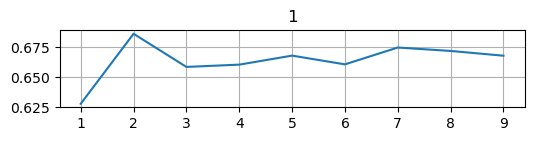

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.37it/s]

0.5501392951344775


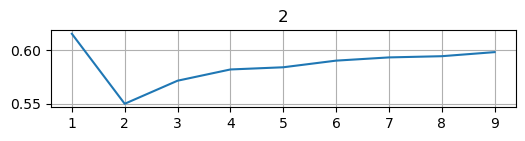

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.20it/s]

0.49325517824379467


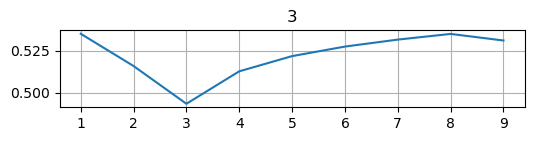

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.88it/s]

0.4855483888544021


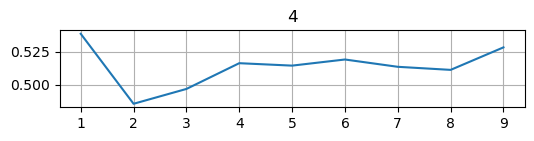

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.59it/s]


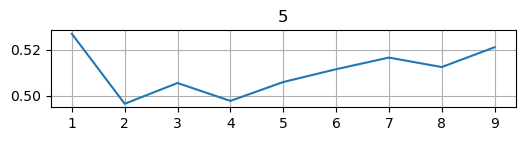

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.44it/s]


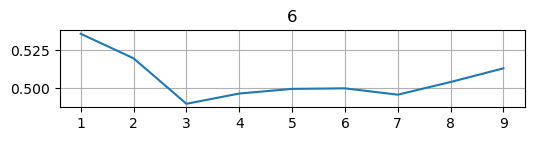

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.28it/s]


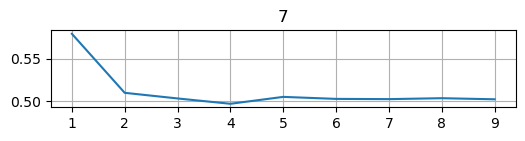

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.09it/s]

0.48501177392830375


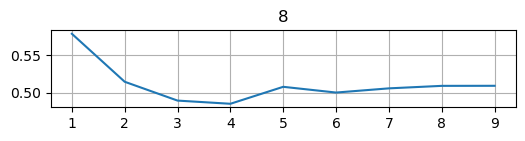

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.83it/s]


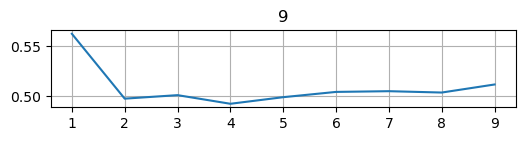

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.89it/s]


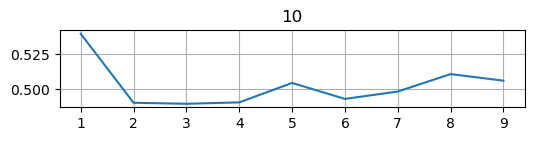

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.80it/s]


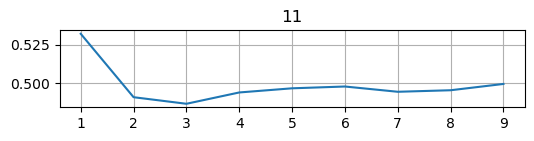

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.74it/s]


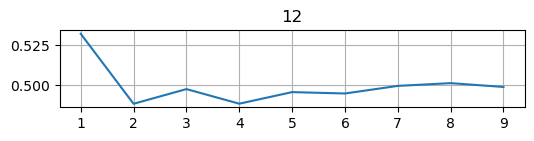

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.67it/s]


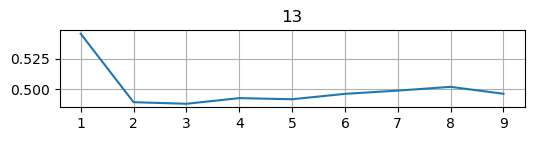

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.54it/s]

0.47788804409849056


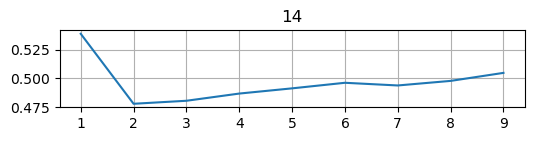

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.47it/s]

0.4640260878153081


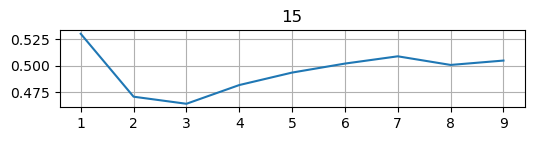

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.43it/s]


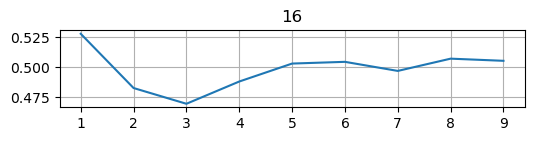

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.32it/s]


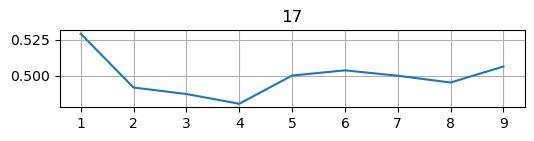

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.30it/s]


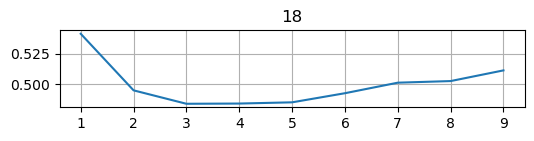

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.22it/s]


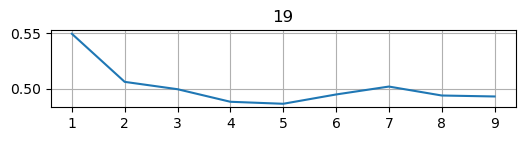

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.02it/s]


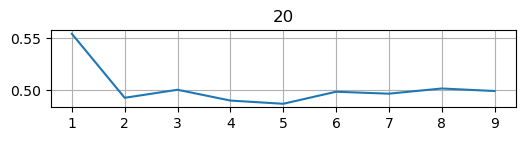

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.17it/s]


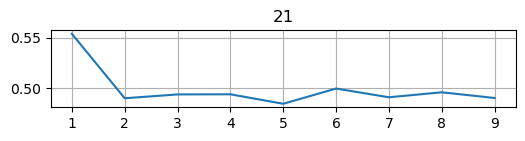

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.07it/s]


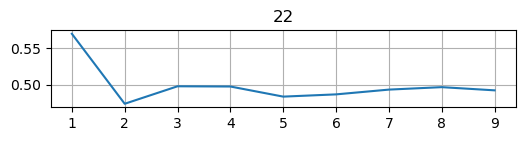

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.83it/s]


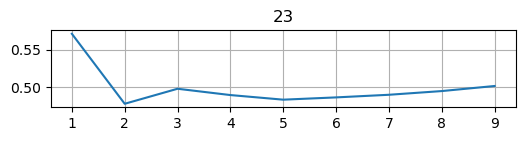

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.84it/s]


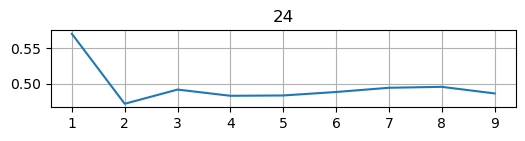

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.90it/s]


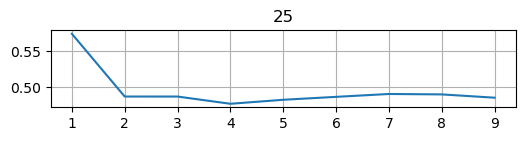

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.93it/s]


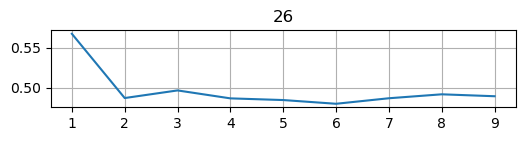

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.82it/s]


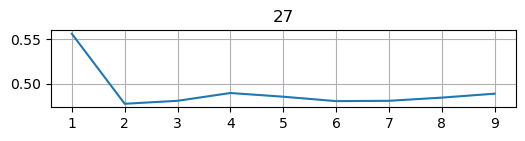

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.80it/s]


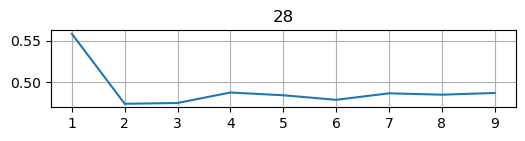

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.86it/s]


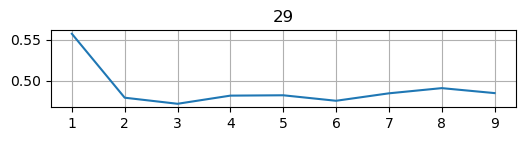

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.82it/s]


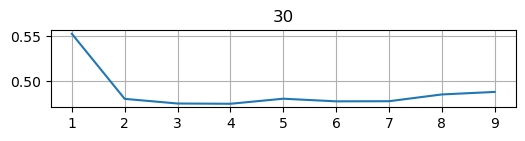

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.81it/s]


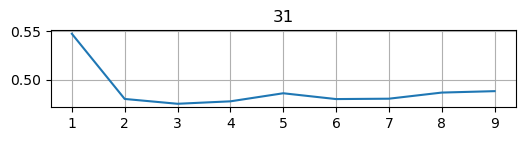

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.81it/s]


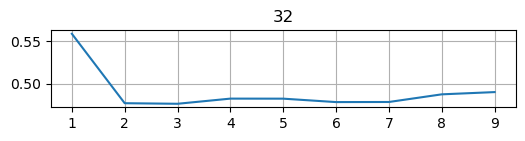

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.80it/s]


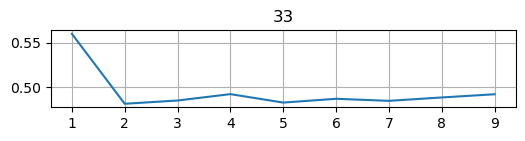

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.76it/s]


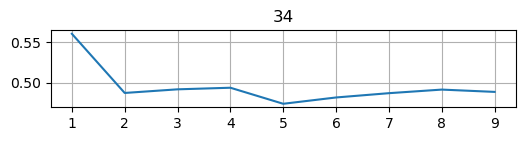

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.58it/s]


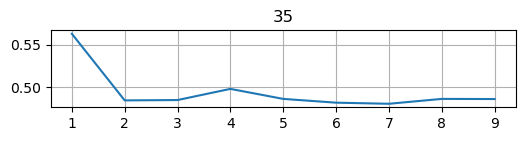

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.62it/s]


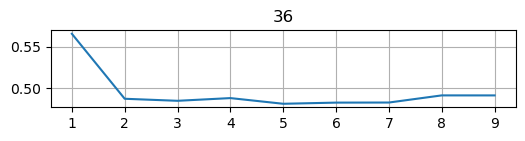

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.63it/s]


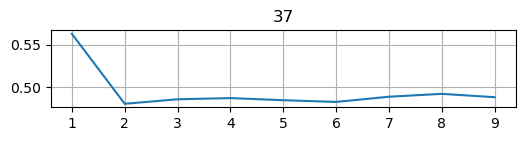

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.63it/s]


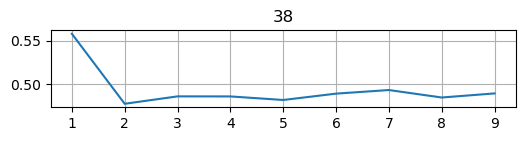

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.51it/s]


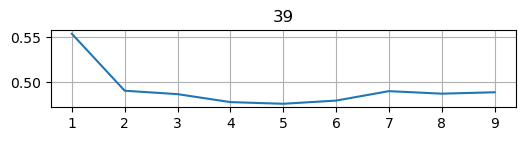

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.56it/s]


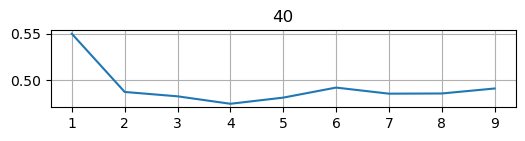

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.55it/s]


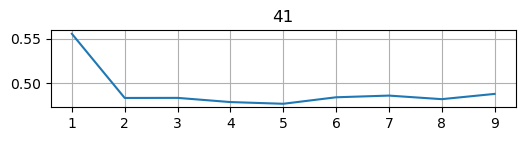

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.44it/s]


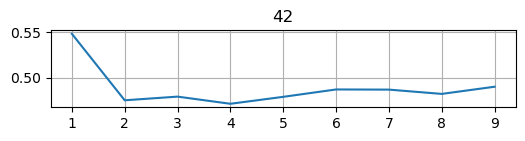

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.51it/s]


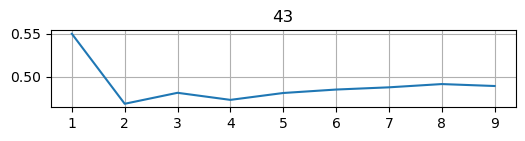

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.48it/s]


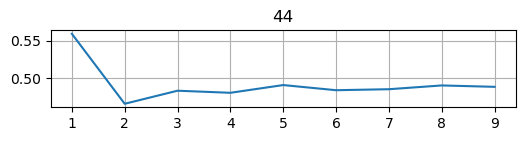

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.39it/s]


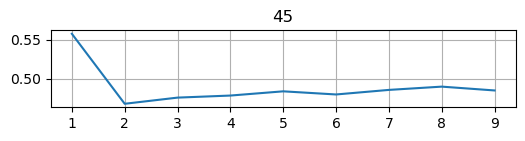

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.47it/s]


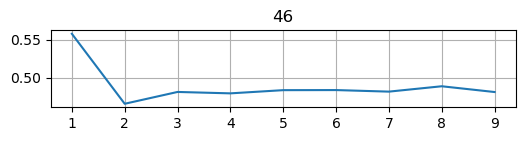

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.46it/s]


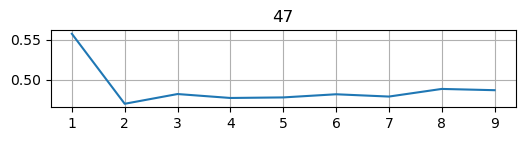

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.44it/s]


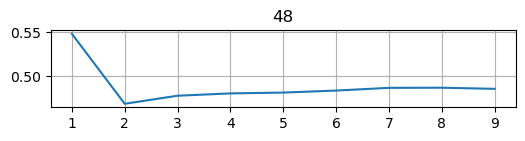

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.40it/s]


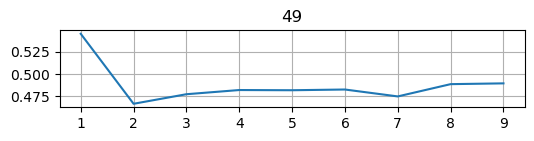

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.30it/s]


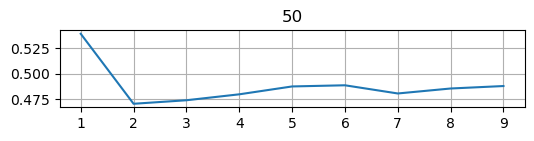

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.40it/s]


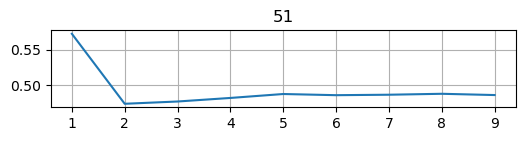

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.38it/s]


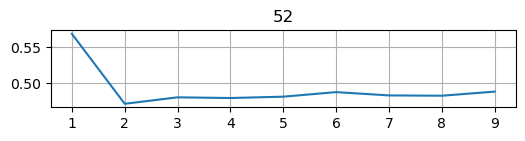

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.35it/s]


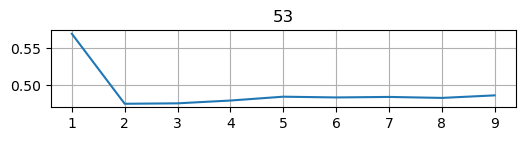

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.35it/s]


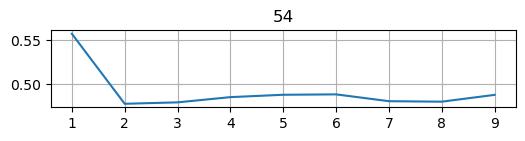

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.31it/s]


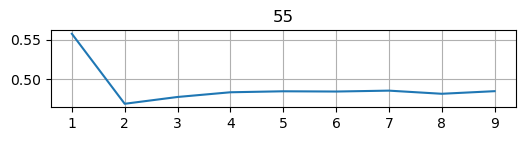

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.36it/s]


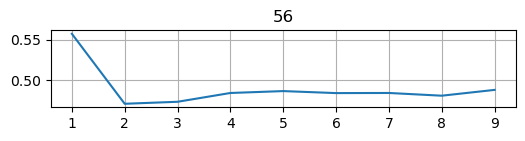

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.33it/s]


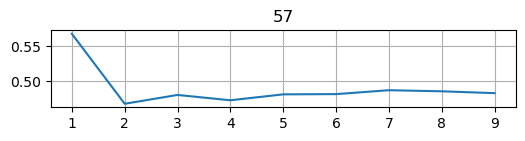

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.11it/s]

0.46369991202153377


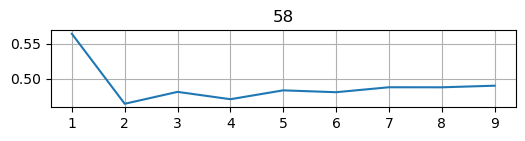

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.27it/s]


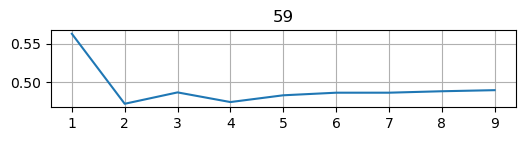

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.28it/s]


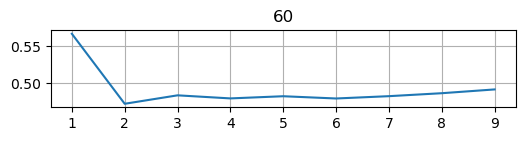

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.29it/s]


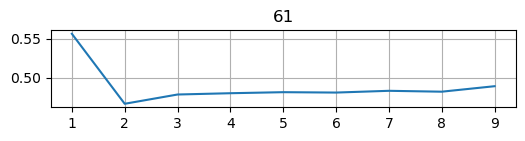

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.26it/s]


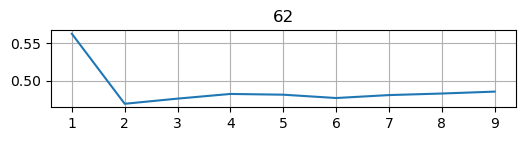

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.22it/s]


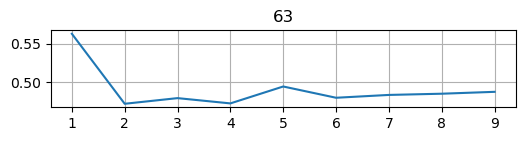

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.14it/s]


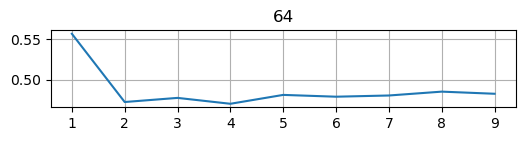

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.20it/s]


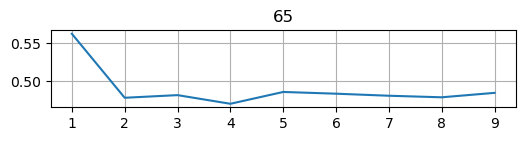

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.14it/s]


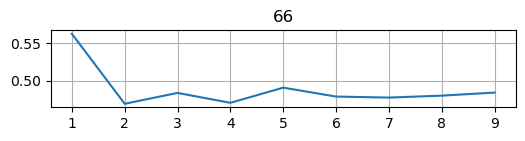

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.16it/s]


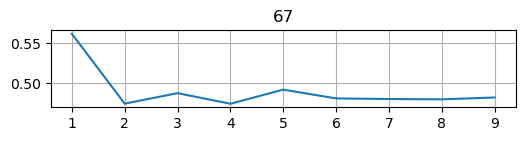

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.09it/s]


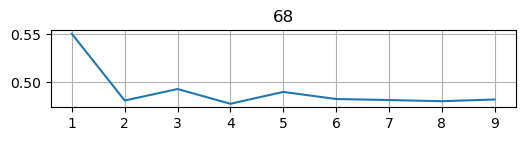

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.16it/s]


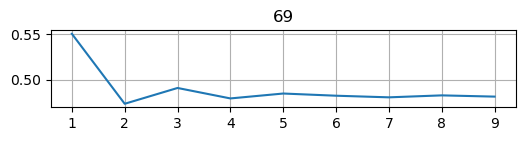

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.06it/s]


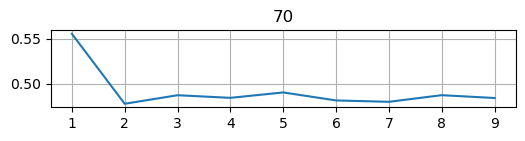

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.11it/s]


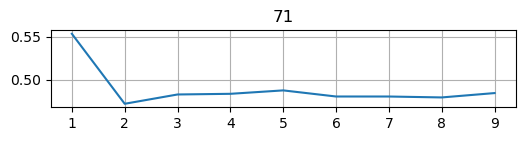

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.14it/s]


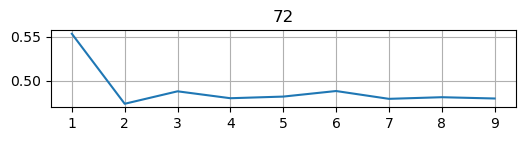

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.14it/s]


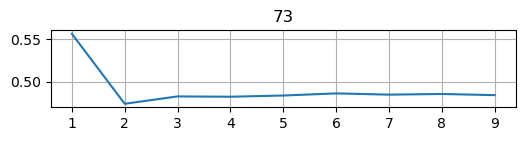

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.15it/s]


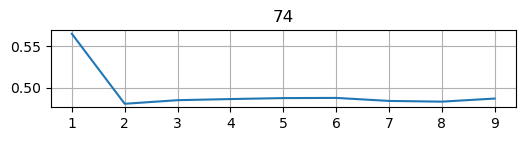

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.14it/s]


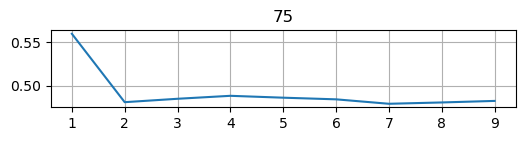

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.06it/s]


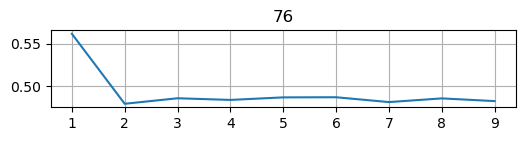

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.11it/s]


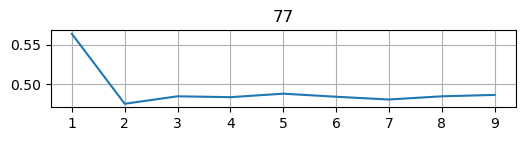

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.12it/s]


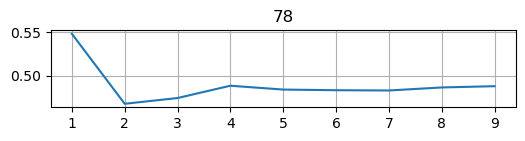

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.10it/s]


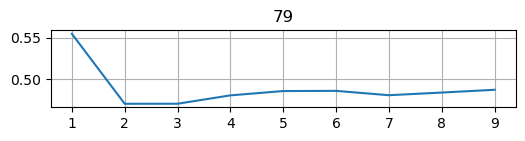

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.03it/s]


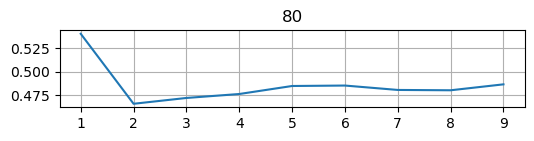

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.05it/s]


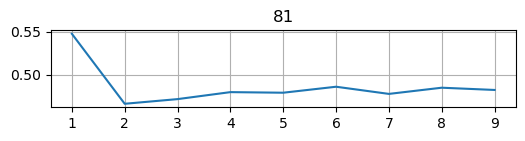

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.03it/s]


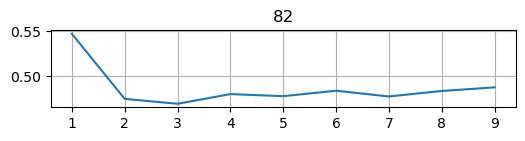

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.07it/s]


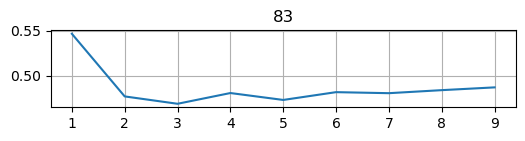

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.08it/s]


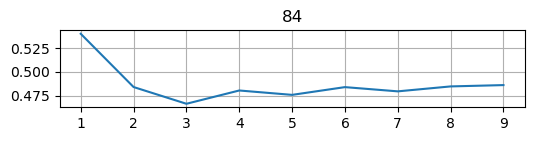

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.09it/s]


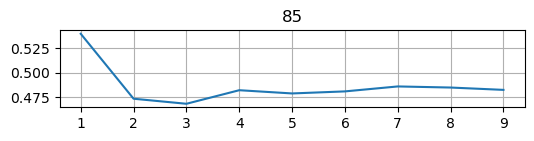

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.06it/s]


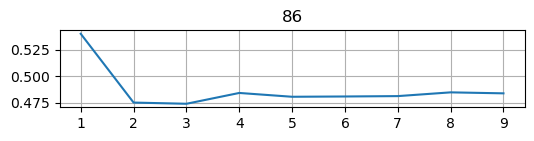

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.06it/s]


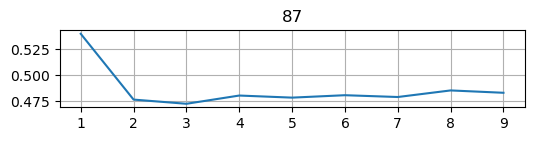

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.03it/s]


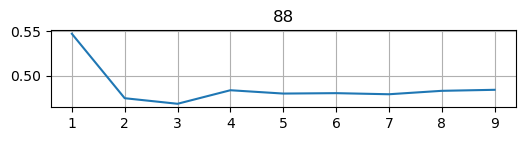

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.07it/s]


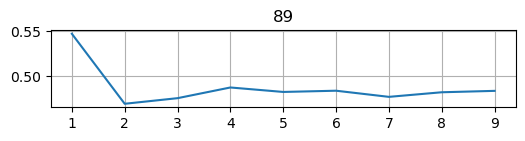

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.06it/s]


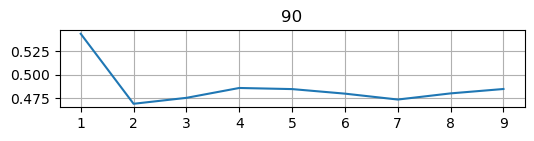

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.00it/s]


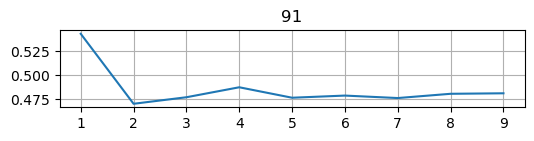

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.05it/s]


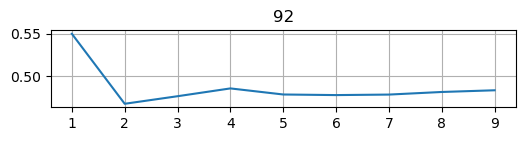

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.05it/s]


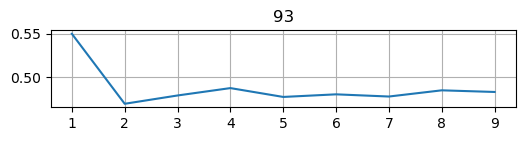

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.00it/s]


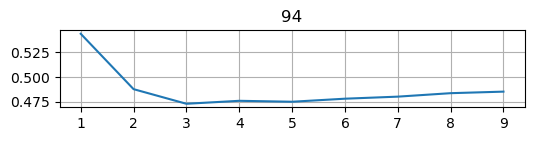

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.98it/s]


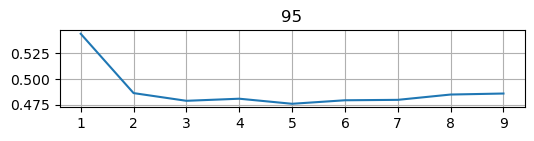

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.02it/s]


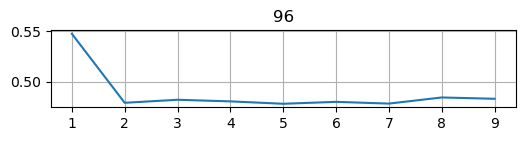

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.02it/s]


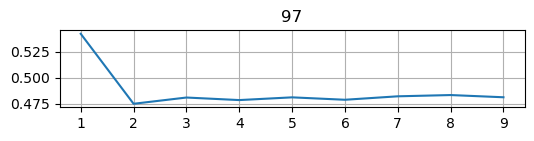

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.83it/s]


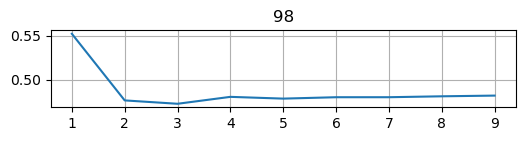

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.96it/s]


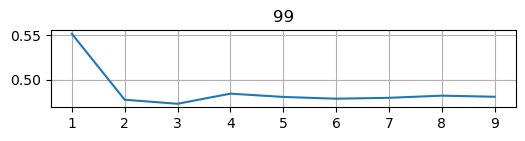

In [38]:
from tqdm import tqdm

predictors = ["Dia_Semana", "Hora", "Minuto", "Gto-SanPedro"]
response = ["Gto-Alonso"]

best_val_error = float('inf')
for split in range(1, 100):
    train_errors = []
    val_errors = []
    ns = range(1, 10)
    for n_trees in tqdm(ns):
        boosting_tree = BoostingRegressionTree(
            n_trees = n_trees,
            shrinkage = 1/n_trees,
            splits = split
        )
        train_error, val_error = cross_validation(boosting_tree, predictors, response)
        train_errors.append(train_error)
        val_errors.append(val_error)

    if min(val_errors) < best_val_error:
        best_val_error = min(val_errors)
        print(best_val_error)
    plt.figure(figsize=(6, 1))
    #plt.plot(ns, train_errors, label="train")
    plt.plot(ns, val_errors, label="val")
    #plt.legend()
    plt.grid()
    plt.title(split)
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.74it/s]

0.4777536703425988


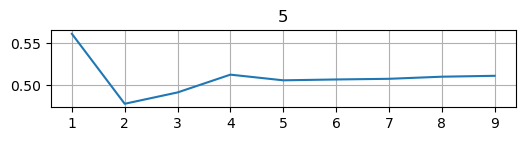

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.24it/s]


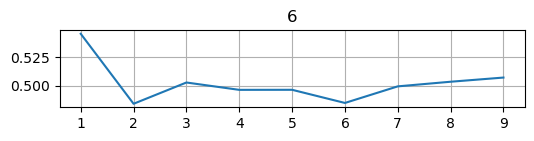

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.08it/s]

0.46624237416676967


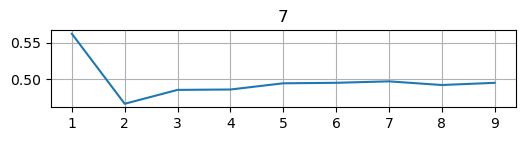

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.92it/s]

0.45559890610572307


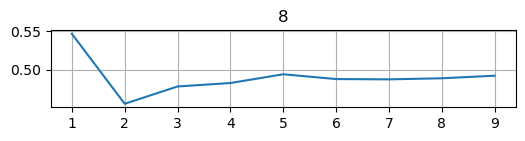

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.61it/s]

0.43999131652323625


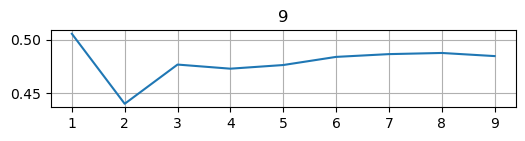

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.61it/s]

0.43651678761206325


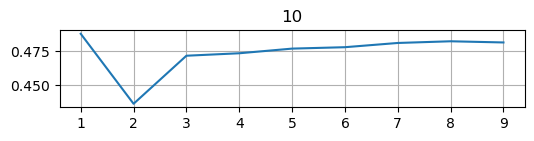

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.48it/s]

0.43542875487907695


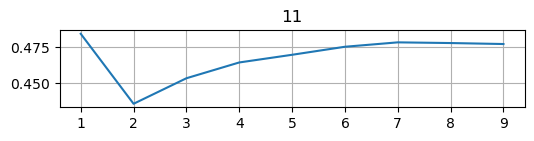

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.41it/s]


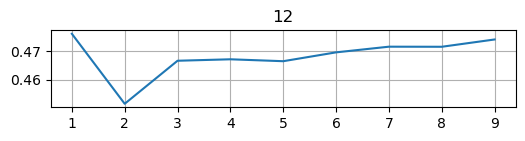

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.30it/s]


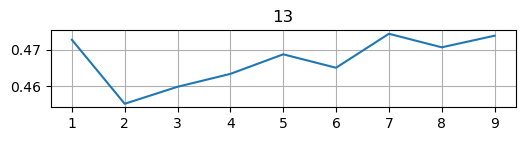

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.16it/s]


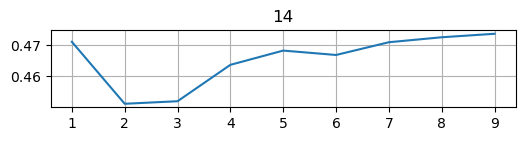

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.12it/s]


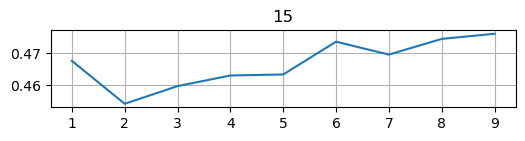

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.79it/s]


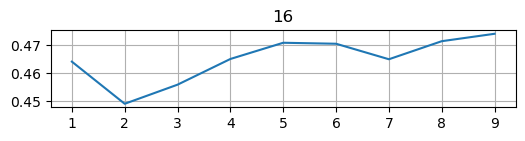

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.00it/s]


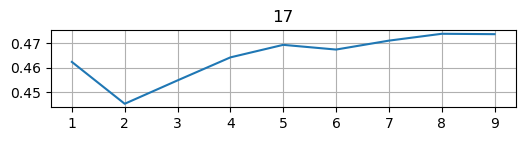

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.93it/s]


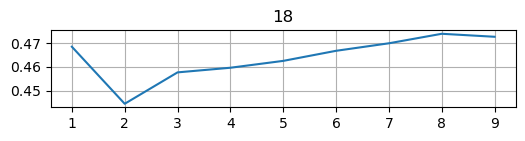

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.77it/s]


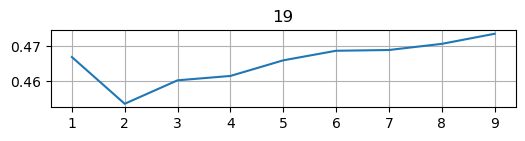

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.78it/s]


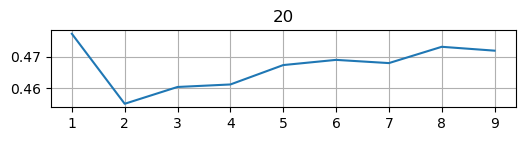

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.72it/s]


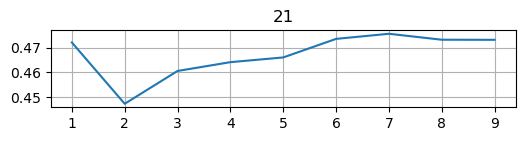

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.68it/s]


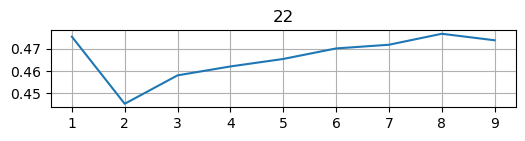

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.64it/s]


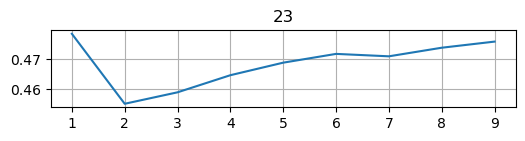

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.48it/s]


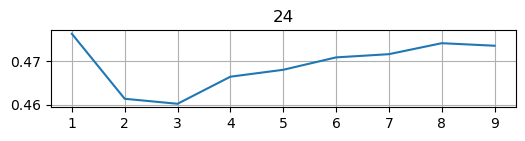

In [27]:
predictors = ["Dia_Semana", "Hora", "Minuto"]
response = ["Gto-Alonso"]

best_val_error = float('inf')
for split in range(5, 25):
    train_errors = []
    val_errors = []
    ns = range(1, 10)
    for n_trees in tqdm(ns):
        boosting_tree = BoostingRegressionTree(
            n_trees = n_trees,
            shrinkage = 1/n_trees,
            splits = split
        )
        train_error, val_error = cross_validation(boosting_tree, predictors, response)
        train_errors.append(train_error)
        val_errors.append(val_error)

    if min(val_errors) < best_val_error:
        best_val_error = min(val_errors)
        print(best_val_error)
    plt.figure(figsize=(6, 1))
    #plt.plot(ns, train_errors, label="train")
    plt.plot(ns, val_errors, label="val")
    #plt.legend()
    plt.grid()
    plt.title(split)
    plt.show()

In [28]:
boosting_tree = BoostingRegressionTree(
    n_trees = 2,
    shrinkage = 1/2,
    splits = 11
)

<>:11: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\h'
/var/folders/y8/gfw8crg95jdf0ymxjbqm7hlm0000gn/T/ipykernel_16995/74086186.py:11: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(y.index, yhat*stds[response].values.ravel() + means[response].values.ravel(), label='$\hat y$', alpha=0.8)


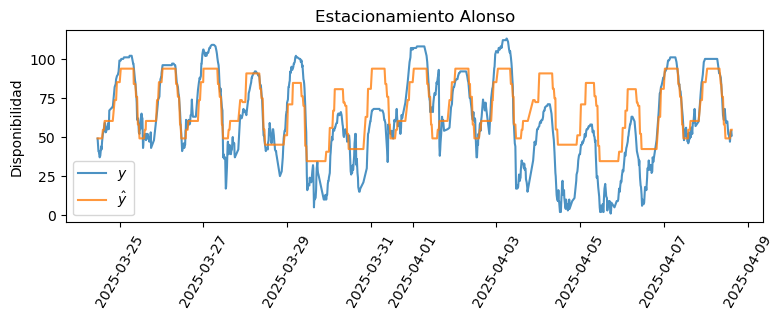

['Dia_Semana', 'Hora', 'Minuto'] 0.3314374092669452


In [29]:
predictors = ["Dia_Semana", "Hora", "Minuto"]
response = ["Gto-Alonso"]

boosting_tree.fit(train[predictors], train[response].values.ravel())
y = test[response]
yhat = boosting_tree.predict(test[predictors])
mse = ((y.values.ravel() - yhat)**2).mean()

plt.figure(figsize=(9, 2.5))
plt.plot(y.index, (y*stds + means)[response].values.ravel(), label='$y$', alpha=0.8)
plt.plot(y.index, yhat*stds[response].values.ravel() + means[response].values.ravel(), label='$\hat y$', alpha=0.8)
plt.xticks(rotation=60)

plt.title("Estacionamiento Alonso")
plt.ylabel("Disponibilidad")
plt.legend()
plt.savefig("media/boosting_tree.jpeg")
plt.show()

print(predictors, mse)